In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Step 1: Data Import and Preprocessing
# 1. Load the provided datasets
data = pd.read_csv('test_data.csv')

# Display basic information about the dataset
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  2534 non-null   object 
 1   crawl_timestamp          2534 non-null   object 
 2   product_url              2534 non-null   object 
 3   product_name             2534 non-null   object 
 4   pid                      2534 non-null   object 
 5   retail_price             2530 non-null   float64
 6   discounted_price         2530 non-null   float64
 7   image                    2534 non-null   object 
 8   is_FK_Advantage_product  2534 non-null   bool   
 9   description              2534 non-null   object 
 10  product_rating           2534 non-null   object 
 11  overall_rating           2534 non-null   object 
 12  brand                    2012 non-null   object 
 13  product_specifications   2529 non-null   object 
dtypes: bool(1), float64(2), 

In [4]:
# 2. Effectively manage missing data, outliers, and data inconsistencies
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

# Fill missing values with an appropriate strategy
data['retail_price'].fillna(data['retail_price'].mean(), inplace=True)
data['discounted_price'].fillna(data['discounted_price'].mean(), inplace=True)
data['brand'].fillna('unknown', inplace=True)
data['product_specifications'].fillna('unknown', inplace=True)

# Check for duplicates and drop them
data.drop_duplicates(inplace=True)

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
pid                          0
retail_price                 4
discounted_price             4
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      522
product_specifications       5
dtype: int64


In [5]:
# 3. Prepare the data for analysis through necessary transformations
# Convert categorical columns to consistent format (e.g., lowercase)
categorical_columns = ['product_name', 'brand']
for col in categorical_columns:
    data[col] = data[col].str.lower()

# Drop columns that are not features
features_to_drop = ['uniq_id', 'crawl_timestamp', 'pid', 'product_url', 'image', 'description', 'product_specifications']
X = data.drop(columns=features_to_drop + ['overall_rating'])

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# Convert categorical features to numerical values using Label Encoding
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Target column
y = data['overall_rating'].apply(lambda x: 0 if x == 'No rating available' else float(x.split()[0]))
# Convert to float to handle decimal ratings

# If you specifically need integers, you can round the float values:
y = y.round().astype(int)  # Round and convert to integers

# Standardize numerical features
numerical_columns = ['retail_price', 'discounted_price', 'product_rating']
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

       retail_price  discounted_price
count   2534.000000       2534.000000
mean    1894.598024       1011.826877
std     2870.315941       1721.529107
min       55.000000         47.000000
25%      850.000000        449.000000
50%     1299.000000        600.000000
75%     2199.000000        958.000000
max    46500.000000      25510.000000


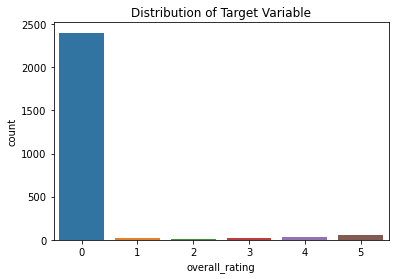

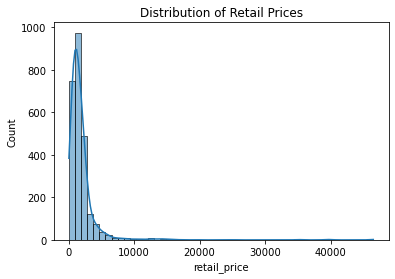

In [6]:
# Step 2: Exploratory Data Analysis (EDA)
# 1. Summary statistics
print(data.describe())

# 2. Visualizations
# Visualize the distribution of target variable
sns.countplot(x=y)
plt.title('Distribution of Target Variable')
plt.show()

# Visualize the distribution of product prices
sns.histplot(data['retail_price'], bins=50, kde=True)
plt.title('Distribution of Retail Prices')
plt.show()

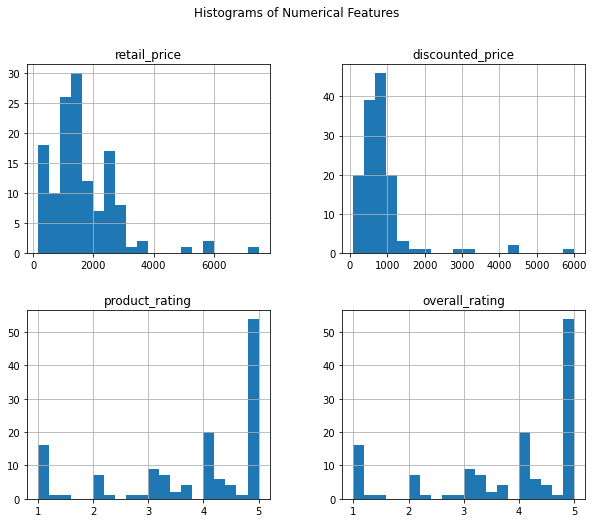

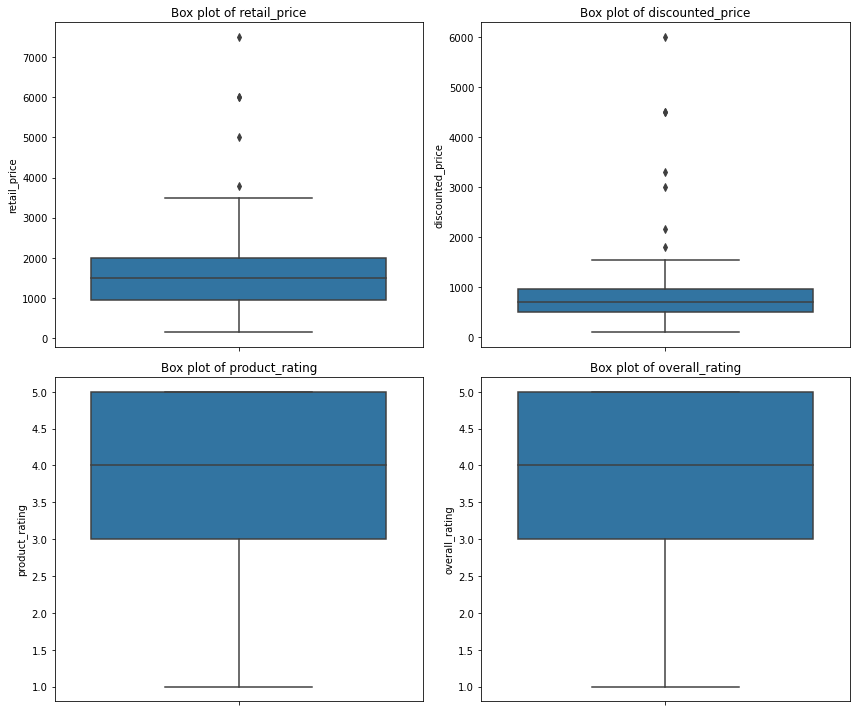

The 'category' column is missing.
Correlation Matrix:
                         retail_price  discounted_price  \
retail_price                 1.000000          0.830286   
discounted_price             0.830286          1.000000   
is_FK_Advantage_product     -0.049140          0.006633   
product_rating               0.066174          0.064122   
overall_rating               0.066174          0.064122   

                         is_FK_Advantage_product  product_rating  \
retail_price                           -0.049140        0.066174   
discounted_price                        0.006633        0.064122   
is_FK_Advantage_product                 1.000000       -0.071421   
product_rating                         -0.071421        1.000000   
overall_rating                         -0.071421        1.000000   

                         overall_rating  
retail_price                   0.066174  
discounted_price               0.064122  
is_FK_Advantage_product       -0.071421  
product_rating

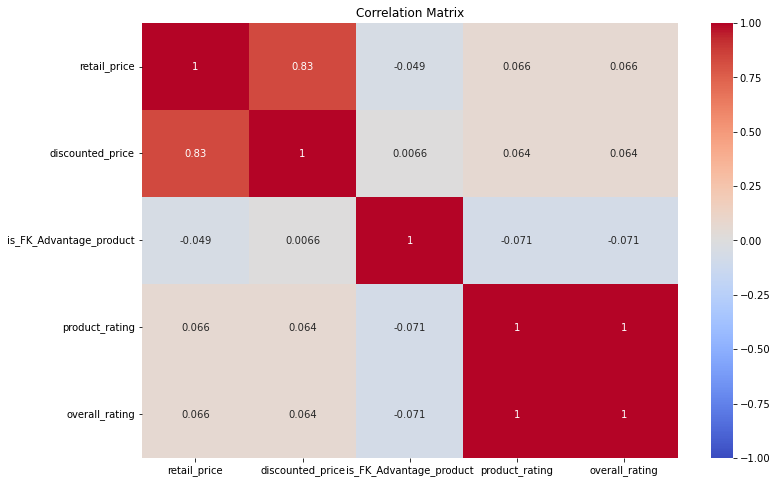

In [36]:
# Select only numerical features for plotting
numerical_features = ['retail_price', 'discounted_price', 'product_rating', 'overall_rating']

# Ensure these features are numeric
for feature in numerical_features:
    data[feature] = pd.to_numeric(data[feature], errors='coerce')

# Drop rows with NaN values in numerical features to avoid plotting errors
data = data.dropna(subset=numerical_features)

# Plot histograms for numerical features
data[numerical_features].hist(figsize=(10, 8), bins=20)
plt.suptitle('Histograms of Numerical Features')
plt.show()

# Plot box plots for numerical features
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, feature in enumerate(numerical_features):
    sns.boxplot(ax=axes[i//2, i%2], y=data[feature])
    axes[i//2, i%2].set_title(f'Box plot of {feature}')
plt.tight_layout()
plt.show()

# 3. Category Distribution
# Assuming 'category' is a column in your dataset
if 'category' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=data['category'], order=data['category'].value_counts().index)
    plt.title('Distribution of Product Categories')
    plt.show()
else:
    print("The 'category' column is missing.")

# 4. Correlations
# Calculate the correlation matrix
corr_matrix = data.corr()
print("Correlation Matrix:")
print(corr_matrix)

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [7]:
# Step 3: Feature Engineering/Text to Features
# 1. Convert text descriptions into numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(data['product_name'])

# Combine TF-IDF features with the rest of the features
X_combined = pd.concat([X.reset_index(drop=True), pd.DataFrame(X_tfidf.toarray())], axis=1)

In [8]:
# Step 4: Machine Learning Model Building
# 1. Build machine learning models using Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Ensure all column names in X_train and X_test are strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [9]:
# 2. Apply deep learning models (optional)
# Build a simple neural network
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

C:\Users\suren\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7280 - loss: 16.3135 - val_accuracy: 0.9581 - val_loss: 1.4655
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8258 - loss: 3.5787 - val_accuracy: 0.9581 - val_loss: 0.4395
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8674 - loss: 1.8081 - val_accuracy: 0.9581 - val_loss: 0.5435
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8632 - loss: 1.2069 - val_accuracy: 0.9581 - val_loss: 0.4200
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9024 - loss: 0.6717 - val_accuracy: 0.9581 - val_loss: 0.4692
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9170 - loss: 0.6208 - val_accuracy: 0.9581 - val_loss: 0.3480
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9160 - loss: 0.6042 - val_accuracy: 0.9581 - val_loss: 0.3401
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9244 - loss: 0.5689 - val_accuracy: 0.9581 - val_los

In [10]:
# Step 5: Model Evaluation
# Logistic Regression evaluation
y_pred = log_reg.predict(X_test)

# 1. Assess using F1-score
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

# 2. Detailed classification report
print(classification_report(y_test, y_pred))

# Deep Learning Model evaluation
y_pred_dl = np.argmax(model.predict(X_test), axis=1)
print(f"F1 Score (Deep Learning): {f1_score(y_test, y_pred_dl, average='weighted')}")
print(classification_report(y_test, y_pred_dl))

F1 Score: 0.9860534164769255
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       489
           1       0.75      0.75      0.75         4
           2       0.00      0.00      0.00         4
           3       0.33      1.00      0.50         2
           4       1.00      1.00      1.00         4
           5       1.00      0.75      0.86         4

    accuracy                           0.99       507
   macro avg       0.68      0.75      0.68       507
weighted avg       0.99      0.99      0.99       507

 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
F1 Score (Deep Learning): 0.9470663719968633
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       489
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         4

    accuracy                           0.96       507
   macro avg       0.16      0.17      0.16       507
weighted avg       0.93      0.96      0.95       507



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# Step 6: Imbalanced Class Handling
# Check class distribution
print(data['overall_rating'].value_counts())

# 1. Address class imbalance using SMOTE
k_neighbors = max(1, min(data['overall_rating'].value_counts()) - 1) 
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train model again on resampled data
log_reg.fit(X_resampled, y_resampled)

# Evaluate model again
y_pred_resampled = log_reg.predict(X_test)
print(f"F1 Score after SMOTE: {f1_score(y_test, y_pred_resampled, average='weighted')}")
print(classification_report(y_test, y_pred_resampled))

No rating available    2399
5                        53
4                        20
1                        16
3                         9
2                         7
3.2                       4
4.2                       4
4.3                       2
4.4                       2
3.5                       2
3.4                       2
3.6                       2
3.7                       2
4.5                       2
4.6                       1
3.3                       1
4.9                       1
1.5                       1
2.3                       1
1.3                       1
2.8                       1
2.7                       1
Name: overall_rating, dtype: int64
F1 Score after SMOTE: 0.9862499367824812
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       489
           1       0.60      0.75      0.67         4
           2       0.50      0.25      0.33         4
           3       0.50      1.00      0.67         2
         

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
# Step 7: Hyperparameter Tuning
param_grid = {'C': [0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, scoring='f1_weighted', cv=5)
grid_search.fit(X_resampled, y_resampled)

# Best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(f"F1 Score after Hyperparameter Tuning: {f1_score(y_test, y_pred_best, average='weighted')}")
print(classification_report(y_test, y_pred_best))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best Hyperparameters: {'C': 10, 'solver': 'liblinear'}
F1 Score after Hyperparameter Tuning: 0.9822842679715317
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       489
           1       0.80      1.00      0.89         4
           2       1.00      0.25      0.40         4
           3       0.25      0.50      0.33         2
           4       0.67      1.00      0.80         4
           5       0.50      0.50      0.50         4

    accuracy                           0.98       507
   macro avg       0.70      0.71      0.65       507
weighted avg       0.99      0.98      0.98       507



In [38]:
# Step 8: Predictions
test_predictions = best_model.predict(X_test)

# Save predictions to a CSV file
predictions_df = pd.DataFrame(test_predictions, columns=['Predicted'])
predictions_df.to_csv('test_predictions.csv', index=False)